In [1]:
import sklearn.preprocessing
import sklearn.pipeline
import scipy.spatial
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [2]:
def calculate_hull(
        X, 
        scale=1.1, 
        padding="scale", 
        n_interpolate=100, 
        interpolation="quadratic_periodic", 
        return_hull_points=False):
    """
    Calculates a "smooth" hull around given points in `X`.
    The different settings have different drawbacks but the given defaults work reasonably well.
    Parameters
    ----------
    X : np.ndarray
        2d-array with 2 columns and `n` rows
    scale : float, optional
        padding strength, by default 1.1
    padding : str, optional
        padding mode, by default "scale"
    n_interpolate : int, optional
        number of interpolation points, by default 100
    interpolation : str or callable(ix,iy,x), optional
        interpolation mode, by default "quadratic_periodic"

    
    """
    
    if padding == "scale":

        # scaling based padding
        scaler = sklearn.pipeline.make_pipeline(
            sklearn.preprocessing.StandardScaler(with_std=False),
            sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1)))
        points_scaled = scaler.fit_transform(X) * scale
        hull_scaled = scipy.spatial.ConvexHull(points_scaled, incremental=True)
        hull_points_scaled = points_scaled[hull_scaled.vertices]
        hull_points = scaler.inverse_transform(hull_points_scaled)
        hull_points = np.concatenate([hull_points, hull_points[:1]])
    
    elif padding == "extend" or isinstance(padding, (float, int)):
        # extension based padding
        # TODO: remove?
        if padding == "extend":
            add = (scale - 1) * np.max([
                X[:,0].max() - X[:,0].min(), 
                X[:,1].max() - X[:,1].min()])
        else:
            add = padding
        points_added = np.concatenate([
            X + [0,add], 
            X - [0,add], 
            X + [add, 0], 
            X - [add, 0]])
        hull = scipy.spatial.ConvexHull(points_added)
        hull_points = points_added[hull.vertices]
        hull_points = np.concatenate([hull_points, hull_points[:1]])
    else:
        raise ValueError(f"Unknown padding mode: {padding}")
    
    # number of interpolated points
    nt = np.linspace(0, 1, n_interpolate)
    
    x, y = hull_points[:,0], hull_points[:,1]
    
    # ensures the same spacing of points between all hull points
    t = np.zeros(x.shape)
    t[1:] = np.sqrt((x[1:] - x[:-1])**2 + (y[1:] - y[:-1])**2)
    t = np.cumsum(t)
    t /= t[-1]

    # interpolation types
    if interpolation is None or interpolation == "linear":
        x2 = scipy.interpolate.interp1d(t, x, kind="linear")(nt)
        y2 = scipy.interpolate.interp1d(t, y, kind="linear")(nt)
    elif interpolation == "quadratic":
        x2 = scipy.interpolate.interp1d(t, x, kind="quadratic")(nt)
        y2 = scipy.interpolate.interp1d(t, y, kind="quadratic")(nt)

    elif interpolation == "quadratic_periodic":
        x2 = scipy.interpolate.splev(nt, scipy.interpolate.splrep(t, x, per=True, k=3))
        y2 = scipy.interpolate.splev(nt, scipy.interpolate.splrep(t, y, per=True, k=3))
    
    elif interpolation == "cubic":
        x2 = scipy.interpolate.CubicSpline(t, x, bc_type="periodic")(nt)
        y2 = scipy.interpolate.CubicSpline(t, y, bc_type="periodic")(nt)
    else:
        x2 = interpolation(t, x, nt)
        y2 = interpolation(t, y, nt)
    
    X_hull = np.concatenate([x2.reshape(-1,1), y2.reshape(-1,1)], axis=1)
    if return_hull_points:
        return X_hull, hull_points
    else:
        return np.power(10,X_hull)







In [3]:
def draw_hull(
        X, 
        scale=1.1, 
        padding="scale", 
        n_interpolate=100, 
        interpolation="quadratic_periodic",
        plot_kwargs=None, 
        ax=None,
        color='k',
        fill_color='r',
        fill_alpha=1,
        alpha=1):
    """Uses `calculate_hull` to draw a hull around given points.

    Parameters
    ----------
    X : np.ndarray
        2d-array with 2 columns and `n` rows
    scale : float, optional
        padding strength, by default 1.1
    padding : str, optional
        padding mode, by default "scale"
    n_interpolate : int, optional
        number of interpolation points, by default 100
    interpolation : str or callable(ix,iy,x), optional
        interpolation mode, by default "quadratic_periodic"
    plot_kwargs : dict, optional
        `matplotlib.pyplot.plot` kwargs, by default None
    ax : `matplotlib.axes.Axes`, optional
        [description], by default None
    """
    default_plot_kwargs = dict(
        color=color,
        linewidth=1
    )
    
    if plot_kwargs is None:
        plot_kwargs = default_plot_kwargs
    else:
        plot_kwargs = {**default_plot_kwargs, **plot_kwargs}

    X_hull = calculate_hull(
        X, scale=scale, padding=padding, n_interpolate=n_interpolate, interpolation=interpolation)
    if ax is None:
        ax= plt.gca()
    plt.plot(X_hull[:,0], X_hull[:,1],alpha=alpha, **plot_kwargs)
    #sns.lineplot(y=X_hull[:,0],x=X_hull[:,1])
    #encircle(X_hull[:,0], X_hull[:,1], fc=fill_color, alpha=alpha)
    plt.fill(X_hull[:,0], X_hull[:,1], color=fill_color, alpha=fill_alpha)
def draw_rounded_hull(X, padding=0.1, line_kwargs=None, ax=None,color='k',linewidth=1):
    """Plots a convex hull around points with rounded corners and a given padding.

    Parameters
    ----------
    X : np.array
        2d array with two columns and n rows
    padding : float, optional
        padding between hull and points, by default 0.1
    line_kwargs : dict, optional
        line kwargs (used for `matplotlib.pyplot.plot` and `matplotlib.patches.Arc`), by default None
    ax : matplotlib.axes.Axes, optional
        axes to plat on, by default None
    """

    default_line_kwargs = dict(
        color=color,
        linewidth=1
        
    )
    if line_kwargs is None:
        line_kwargs = default_line_kwargs
    else:
        line_kwargs = {**default_line_kwargs, **line_kwargs}

    if ax is None:
        ax = plt.gca()

    hull = scipy.spatial.ConvexHull(X)
    hull_points = X[hull.vertices]

    hull_points = np.concatenate([hull_points[[-1]], hull_points, hull_points[[0]]])

    diameter = padding * 2
    for i in range(1, hull_points.shape[0] - 1):

        # line
        
        
        
        norm_next = np.flip(hull_points[i] - hull_points[i + 1]) * [-1, 1]
        norm_next /= np.linalg.norm(norm_next)

        norm_prev = np.flip(hull_points[i - 1] - hull_points[i]) * [-1, 1]
        norm_prev /= np.linalg.norm(norm_prev)

        # plot line
        line = hull_points[i:i+2] + norm_next * diameter / 2
        ax.plot(line[:,0], line[:,1], **line_kwargs) 
        #encircle(line[:,0], line[:,1], fc="red", alpha=0.2)
        
        # arc

        angle_next = np.rad2deg(np.arccos(np.dot(norm_next, [1,0])))
        if norm_next[1] < 0:
            angle_next = 360 - angle_next

        angle_prev = np.rad2deg(np.arccos(np.dot(norm_prev, [1,0])))
        if norm_prev[1] < 0:
            angle_prev = 360 - angle_prev

        arc = patches.Arc(
            hull_points[i], 
            diameter, diameter,
            angle=0, fill=False, theta1=angle_prev, theta2=angle_next,
            **line_kwargs)

        ax.add_patch(arc)

In [4]:
path='/content/drive/My Drive/BUOYS/Charts/Ashby charts/data.csv'

data=pd.read_csv(path)
#data.head()

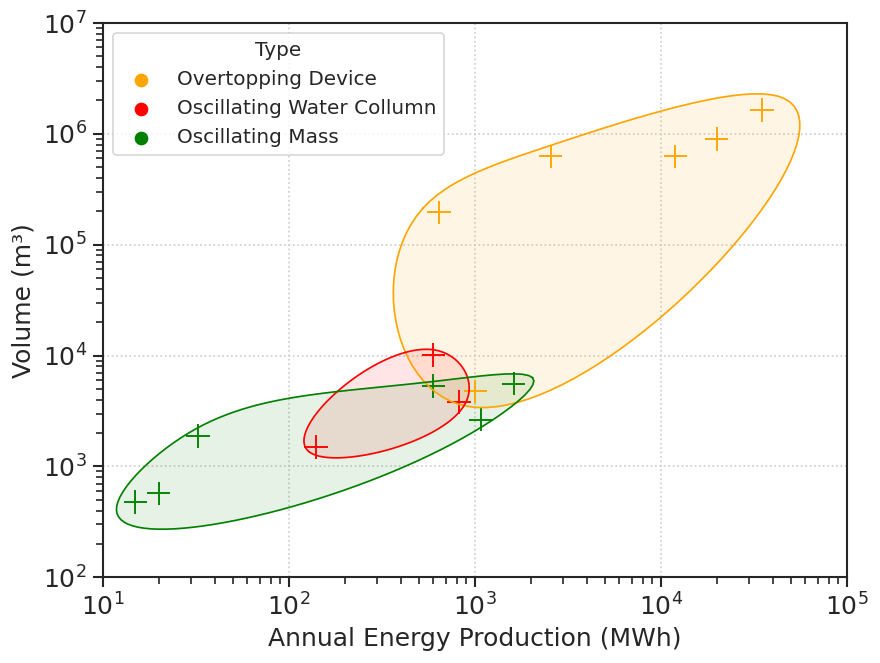

In [11]:
plt.figure(figsize=(8,6),facecolor='w',dpi=120)
sns.set_style('ticks')
sns.set_context('notebook', font_scale = 1) #notebook,paper,talk,poster


colors = ['orange','red','green']
myPalette = sns.set_palette(sns.color_palette(colors))


dd = pd.merge(data.Annual_Energy_Production, data.Volume, right_index = True,left_index = True)
dd = pd.merge(dd, data.Type, right_index = True,left_index = True)   
dd.fillna(0,inplace=True)
dd = dd[(dd.Volume> 10) & (dd.Annual_Energy_Production > 10)]
#print(dd)







draw_hull(np.log10(dd[dd.Type=='Overtopping Device'].iloc[:,0:2]),color=colors[0],fill_color=colors[0],alpha=1,fill_alpha=0.1)
draw_hull(np.log10(dd[dd.Type=='Oscillating Water Collumn'].iloc[:,0:2]),color=colors[1],fill_color=colors[1],alpha=1,fill_alpha=0.1)
draw_hull(np.log10(dd[dd.Type=='Oscillating Mass'].iloc[:,0:2]),color=colors[2],fill_color=colors[2],alpha=1,fill_alpha=0.1)

sns.scatterplot(x='Annual_Energy_Production',y='Volume',data=dd,hue='Type',palette=myPalette,marker='+',s=200,alpha=1)

plt.xlabel('Annual Energy Production (MWh)',fontsize=15)
plt.ylabel('Volume (m\u00b3)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xscale('log')
plt.yscale('log')

plt.axis([10,100000,100,10000000])
plt.grid(visible=True, which='major',color='0.8', linestyle=':')
plt.legend(title="Type",markerscale=1.2,fontsize=12,title_fontsize=12,loc='upper left')
